# Preparing the pickle files for `State-evolution` cluster runs of particles transitioning through the quadrupole lens

Particles propagate from a field in z to the quadrupole field in the xy plane back into a field in z.  
The z field is corresponding to a linearly varying electric field required for rabid adiabatic passage.  
`trajectory idx` is iterated over on the cluster

In [1]:
from utils.fields import *
from utils.trajectories import *
from utils.setfontsize import *
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
pickle_dir = 'options pickles/'
trajectory_dir = 'trajectories/'

In [3]:
from trajectories import *
positions = load_trajectories(trajectory_dir+'positions_545.mat')
velocities = load_velocities(trajectory_dir+'velocities_545.mat')

t, (xT, yT, zT), (xVelocity, yVelocity, zVelocity) = get_time_position_velocity(positions, velocities)

In [4]:
def makeInterpolate(t,x,y,z):
    """
    Note that for the field simulations the molecular
    beam directin is z.
    Interpolating the trajectories, quadruatic for 
    gravitational shift, linear otherwise.
    """
    intTrajX = interp1d(t, x, kind = 'linear')
    intTrajY = interp1d(t, y, kind = 'quadratic')
    intTrajZ = interp1d(t, z, kind = 'linear')

    rootfun = lambda t: intTrajZ(t) - (0.8052-0.15)
    tstart = brentq(rootfun, 0.001, 0.015)
    rootfun = lambda t: intTrajZ(t) - (0.8052+0.6+0.15)
    tstop = brentq(rootfun, 0.001, 0.015)
    
    z -= (0.8052-0.15) + 0.45
    
    intTrajX = interp1d(t-tstart, x, kind = 'linear')
    intTrajY = interp1d(t-tstart, y, kind = 'quadratic')
    intTrajZ = interp1d(t-tstart, z, kind = 'linear')

    tstop = brentq(intTrajZ, 0,tstop-tstart)
    
    return intTrajX, intTrajY, intTrajZ, tstop

In [5]:
interpolateTrajectories = []
for idInt in range(t.shape[1]):
    interpolateTrajectories.append((makeInterpolate(t[:,idInt], xT[:,idInt], yT[:,idInt], zT[:,idInt])))

In [6]:
del t, xT, yT, zT, xVelocity, yVelocity, zVelocity

generating the interpolating functions for the electric fields

In [223]:
def fit_potential_z_mirror(x_grid, y_grid, z_grid, pot_grid, r, mirror_z):
    idx = find_nearest(x_grid, np.sqrt(r**2/2))
    idy = find_nearest(y_grid, np.sqrt(r**2/2))

    maskz = z_grid < mirror_z
    f = np.abs(pot_grid[idx, idy, :].flatten())[maskz]
    f -= f.min()
    f /= f.max()
    
    l = maskz.sum()
    z_spliced = np.zeros(l*2)
    ind_sort = np.argsort(-z_grid[maskz])
    z_spliced[:l] = z_grid[maskz]
    z_spliced[-l:] = z_grid[maskz]+(z_spliced[l-1]-z_spliced.min())+(z_spliced[1]-z_spliced[0])
    f_spliced = np.zeros(l*2)
    f_spliced[:l] = f
    f_spliced[-l:] = f[ind_sort]
    intfun = UnivariateSpline(z_spliced, f_spliced, s = 0)
    return intfun

In [224]:
def fit_potential_xyz_mirror(fname, rxy, rz, zmaskxy, mirror_z, scale = 1):
    x,y,z,potential = load_potential(fname)
    potential *= scale
    (x_grid, y_grid, z_grid), pot_grid = create_grid_potential(x,y,z,potential)
    intfun = fit_potential_z_mirror(x_grid,y_grid,z_grid,pot_grid,rz,mirror_z)
    c = fit_potential_xy(x,y,z,potential, rxy, zmaskxy)

    return c, intfun

In [226]:
field_dir = "D:/Adiabatic Transfer/propagation/fields/"
fname_potential_ring1 = 'potentialAdiabaticRapidPassageRing1_5kV.fld'
fname_potential_ring2 = 'potentialAdiabaticRapidPassageRing2_0.75kV.fld'
fname_potential_quad  = 'potentialAdiabaticRapidPassageQuadrupole.fld'

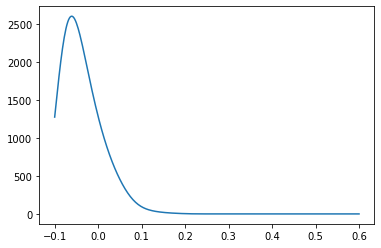

In [221]:
x,y,z,potential = load_potential(field_dir+fname_potential_ring1)
mask = (x == 0) & (y == 0)
plt.plot(z[mask], potential[mask])

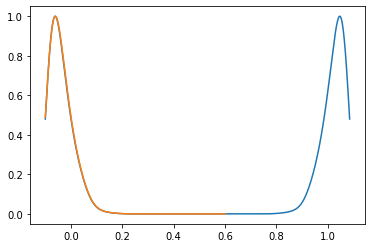

In [222]:
c, intfun = fit_potential_xyz_mirror(field_dir+fname_potential_ring1, 0.03, 0.01, 0.1, 493e-3)
mask = (np.abs(x-0) < 5e-4) & (np.abs(y-0) < 5e-4)
zi = np.linspace(z.min(), (493e-3)*2-z.min(), 1001)
plt.plot(zi, intfun(zi))
plt.plot(z[mask], potential[mask]/potential[mask].max())

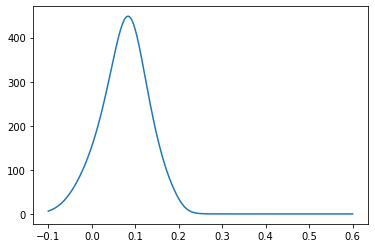

In [196]:
x,y,z,potential = load_potential(field_dir+fname_potential_ring2)
mask = (np.abs(x-0) < 5e-4) & (np.abs(y-0) < 5e-4)
plt.plot(z[mask], potential[mask])

In [214]:
c, intfun = fit_potential_xyz_mirror(field_dir+fname_potential_ring2, 0.03, 0.01, 0.1, 493e-3)

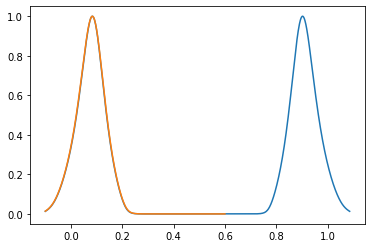

In [219]:
mask = (np.abs(x-0) < 5e-4) & (np.abs(y-0) < 5e-4)
zi = np.linspace(z.min(), (493e-3)*2-z.min(), 1001)
plt.plot(zi, intfun(zi))
plt.plot(z[mask], potential[mask]/potential[mask].max())

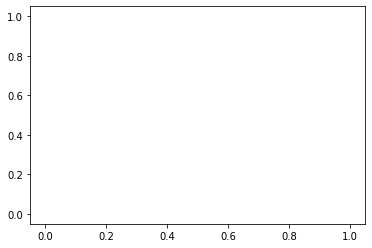

In [318]:
x,y,z,potential = load_potential(field_dir+fname_potential_quad)


In [332]:
x = x.round(3)y
y = y.round(3)
z = z.round(3)

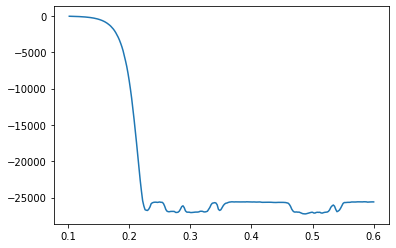

In [341]:
mask = (x == 0.015) & (y == 0.015)
plt.plot(z[mask & (z > 0.1) & (z < 1)], potential[mask & (z > 0.1) & (z < 1)])

In [225]:
del x,y,z,potential

In [229]:
c_ring1, intfun_ring1 = fit_potential_xyz_mirror(field_dir+fname_potential_ring1, 0.03, 0.01, 0.1, 493e-3)
c_ring2, intfun_ring2 = fit_potential_xyz_mirror(field_dir+fname_potential_ring1, 0.03, 0.01, 0.1, 493e-3)

In [291]:
c_quad, intfun_quad   = fit_potential_xyz_mirror(field_dir+fname_potential_quad, 0.025, 0.03, 0.4, 493e-3)

In [304]:
print(polynomial.polyval2d(0,0,polynomial.polyder(c_quad, axis=0))/100)
print(polynomial.polyval2d(0,0,polynomial.polyder(c_quad, axis=1))/100)

-81.52329845183084
121.84535468375627


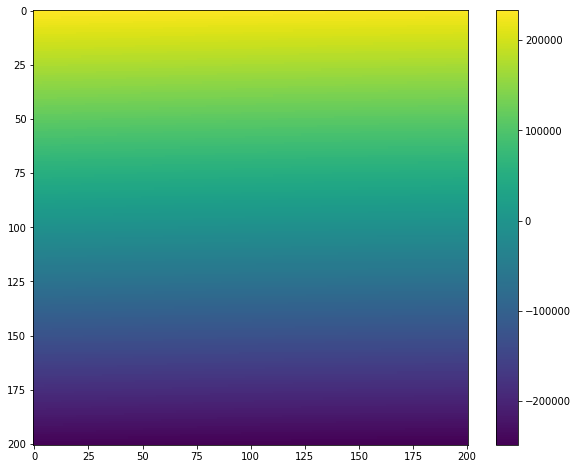

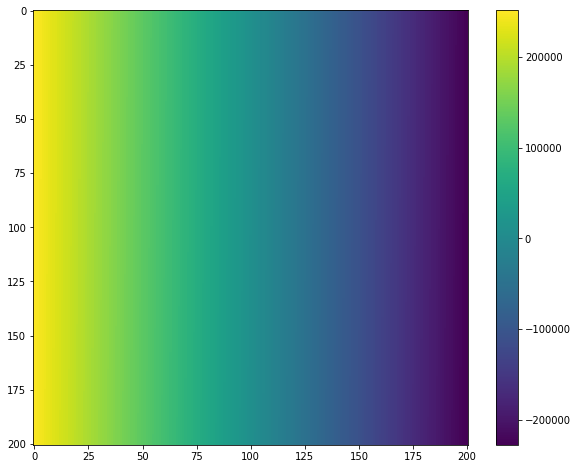

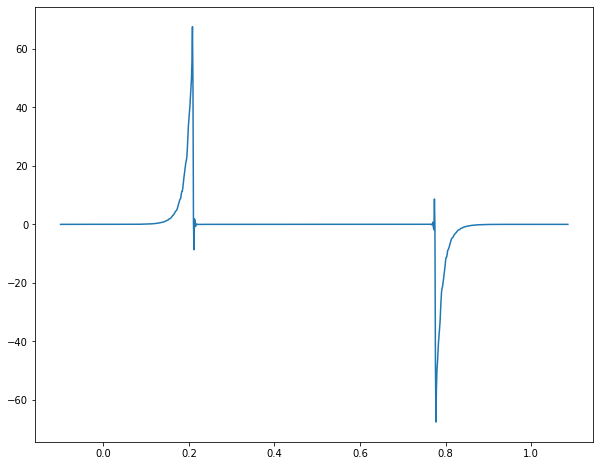

In [309]:
X,Y = np.meshgrid(np.linspace(-2e-3,2e-3,201), np.linspace(-2e-3,2e-3,201))
fig, ax = plt.subplots(figsize = (10,8))
cax = ax.imshow(polynomial.polyval2d(X,Y,polynomial.polyder(c_quad, axis=0)))
fig.colorbar(cax)
fig, ax = plt.subplots(figsize = (10,8))
cax = ax.imshow(polynomial.polyval2d(X,Y,polynomial.polyder(c_quad, axis=1)))
fig.colorbar(cax)
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(zi, intfun_quad.derivative()(zi))

In [292]:
def combine_interpolations(ring_1, ring_2, quad):
    c_ring1, intfun_ring1 = ring_1
    c_ring2, intfun_ring2 = ring_2
    c_quad, intfun_quad   = quad
    
    c_ring1_xder = polynomial.polyder(c_ring1, axis = 0)
    c_ring1_yder = polynomial.polyder(c_ring1, axis = 1)
    c_ring2_xder = polynomial.polyder(c_ring2, axis = 0)
    c_ring2_yder = polynomial.polyder(c_ring2, axis = 1)
    c_quad_xder  = polynomial.polyder(c_quad, axis = 0)
    c_quad_yder  = polynomial.polyder(c_quad, axis = 1)
        
    Ex = lambda x,y,z: -(intfun_ring1(z)*polynomial.polyval2d(x,y,c_ring1_xder) + \
                         intfun_ring2(z)*polynomial.polyval2d(x,y,c_ring2_xder) + \
                         intfun_quad(z)*polynomial.polyval2d(x,y,c_quad_xder))/100
    Ey = lambda x,y,z: -(intfun_ring1(z)*polynomial.polyval2d(x,y,c_ring1_yder) + \
                         intfun_ring2(z)*polynomial.polyval2d(x,y,c_ring2_yder) + \
                         intfun_quad(z)*polynomial.polyval2d(x,y,c_quad_yder))/100
    Ez = lambda x,y,z: -(intfun_ring1.derivative()(z)*polynomial.polyval2d(x,y,c_ring1) + \
                         intfun_ring2.derivative()(z)*polynomial.polyval2d(x,y,c_ring2) + \
                         intfun_quad.derivative()(z)*polynomial.polyval2d(x,y,c_quad))/100
    return Ex, Ey, Ez

In [293]:
Ex, Ey, Ez = combine_interpolations((c_ring1, intfun_ring1), (c_ring2, intfun_ring2), (c_quad, intfun_quad))

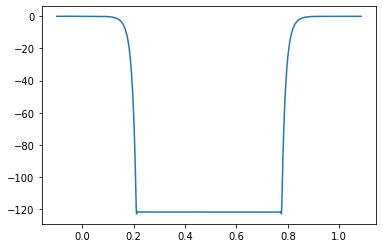

In [306]:
plt.plot(zi, Ey(0,0,zi))

### Checking if the fields make physical sense

In [ ]:
Ex = lambda x,y,z: intfunP_offset(z)*polynomial.polyval2d(x,y,x_cPOder)/100
Ey = lambda x,y,z: intfunP_offset(z)*polynomial.polyval2d(x,y,y_cPOder)/100
Ez = lambda x,y,z: intfunP_offset.derivative()(z)*polynomial.polyval2d(x,y,cP_offset)/100

coords = lambda t: (0*t, 0*t, -0.45+t)

In [ ]:
t = np.linspace(0, 0.9, 1000)

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(t, Ex(*coords(t)), lw = 3)
ax.set_title('Ex from 1kV offset homogeneous field plates')
ax.set_ylabel('E [V/cm]')
ax.set_xlabel('z [m]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(t, Ey(*coords(t)), lw = 3)
ax.set_title('Ey from 1kV offset homogeneous field plates')
ax.set_ylabel('E [V/cm]')
ax.set_xlabel('z [m]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(t, Ez(*coords(t)), lw = 3)
ax.set_title('Ez from 1kV offset homogeneous field plates')
ax.set_ylabel('E [V/cm]')
ax.set_xlabel('z [m]')
set_fontsize(ax, 15)

Fields look as expected, no field in x and y, with the only field being the small transitions from the homogeneous field to the outer field.

In [ ]:
Ex = lambda x,y,z,offset,amp: offset*intfunP_offset(z)*polynomial.polyval2d(x,y,x_cPOder)/100 + \
                              amp*intfunP(z)*polynomial.polyval2d(x,y,x_cPder)/100
Ey = lambda x,y,z,offset,amp: offset*intfunP_offset(z)*polynomial.polyval2d(x,y,y_cPOder)/100 + \
                              amp*intfunP(z)*polynomial.polyval2d(x,y,y_cPder)/100
Ez = lambda x,y,z,offset,amp: offset*intfunP_offset.derivative()(z)*polynomial.polyval2d(x,y,cP_offset)/100 + \
                              amp*intfunP.derivative()(z)*polynomial.polyval2d(x,y,cP)/100

coords = lambda t: (0*t, 0*t, -0.45+t)

In [ ]:
t = np.linspace(0, 0.9, 1000)
offset = 1
amp = 5

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(t, Ex(*coords(t), offset, amp), lw = 3)
ax.set_title(f'Ex field plates; field is {amp*84.4:.1f} V/cm & offset by {offset*-1:.1f} kV')
ax.set_ylabel('E [V/cm]')
ax.set_xlabel('z [m]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(t, Ey(*coords(t), offset, amp), lw = 3)
ax.set_title(f'Ey field plates; field is {amp*84.4:.1f} V/cm & offset by {offset*-1:.1f} kV')
ax.set_ylabel('E [V/cm]')
ax.set_xlabel('z [m]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(t, Ez(*coords(t), offset, amp), lw = 3)
ax.set_title(f'Ez field plates; field is {amp*84.4:.1f} V/cm & offset by {offset*-1:.1f} kV ')
ax.set_ylabel('E [V/cm]')
ax.set_xlabel('z [m]')
set_fontsize(ax, 15)